### ∆ Giai đoạn 5: Phân tích nguyên nhân & mô hình dự đoán

**Mục tiêu:**

Xây dựng mô hình phân loại để dự đoán khả năng một nhân viên sẽ nghỉ việc (Attrition) dựa trên các đặc điểm nhân sự hiện tại. Mục tiêu là:

- Phát hiện các yếu tố quan trọng gây ra nghỉ việc.

- Tạo công cụ hỗ trợ phòng nhân sự đưa ra chiến lược giữ chân nhân tài.

#### 1. Tiền xử lý dữ liệu


One-hot encode cho các biến phân loại

Scale cho các biến số

- Đọc dữ liệu

In [17]:
# Thư viện cơ bản
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import classification_report, roc_auc_score

# Vẽ biểu đồ
import matplotlib.pyplot as plt
import seaborn as sns

# Đọc dữ liệu gốc để xử lý đầy đủ
df_raw = pd.read_csv("Data/ibm_hr_clean.csv")
df = df_raw.copy()

- Biến đổi giá trị nhị phân và loại bỏ cột không cần thiết

In [18]:
# Chuẩn hóa dữ liệu
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
df['OverTime'] = df['OverTime'].map({'Yes': 1, 'No': 0})

# Loại bỏ cột dư thừa
df.drop(columns=['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber'], inplace=True)

- Mã hóa biến phân loại

In [19]:
# Target variable
target_col = 'Attrition'

# Numerical variables
numerical_cols = [
    'Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 
    'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 
    'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear', 
    'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 
    'YearsWithCurrManager'
]

# Categorical variables
categorical_cols = [
    'BusinessTravel', 'Department', 'EducationField', 
    'Gender', 'JobRole', 'MaritalStatus', 'OverTime'
]

# Ordinal variables
ordinal_cols = [
    'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 
    'JobLevel', 'JobSatisfaction', 'PerformanceRating', 
    'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance'
]

# Columns to drop
drop_cols = ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber']

In [20]:
# Lưu lại cột đích và tách biến đầu vào
target = 'Attrition'
X = df.drop(columns=[target])
y = df[target]

# One-hot encoding các cột phân loại
categorical_cols = X.select_dtypes(include='object').columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Xử lý dữ liệu số
X_encoded = X_encoded.apply(pd.to_numeric, errors='coerce')
X_encoded = X_encoded.fillna(0)

# Scale dữ liệu
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_encoded), columns=X_encoded.columns)


- Chia tập train/test và oversample

In [21]:

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# SMOTE (bây giờ OK vì X_train toàn số)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

#### 2. Huấn luyện mô hình

Decision Tree

In [22]:


dt = DecisionTreeClassifier(random_state=42, max_depth=5)
dt.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, random_state=42)

Logistic Regression

In [23]:


lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

#### 3. Đánh giá mô hình

Decision Tree

In [24]:

y_pred_dt = dt.predict(X_test)
y_proba_dt = dt.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_dt))
print("ROC AUC Score (Decision Tree):", roc_auc_score(y_test, y_proba_dt))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       247
           1       0.47      0.19      0.27        47

    accuracy                           0.84       294
   macro avg       0.67      0.58      0.59       294
weighted avg       0.80      0.84      0.81       294

ROC AUC Score (Decision Tree): 0.6591437677663883


Logistic Regression

In [25]:
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_lr))
print("ROC AUC Score (Logistic Regression):", roc_auc_score(y_test, y_proba_lr))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       247
           1       0.60      0.32      0.42        47

    accuracy                           0.86       294
   macro avg       0.74      0.64      0.67       294
weighted avg       0.84      0.86      0.84       294

ROC AUC Score (Logistic Regression): 0.8370229993970195


| Mô hình             | Accuracy | ROC AUC Score |
| ------------------- | -------- | ------------- |
| Decision Tree       | ~0.84   | \~0.66        |
| Logistic Regression | ~0.86   | \~0.84       |


✅ Nhận xét:

- Logistic Regression tốt hơn rõ rệt về ROC AUC:

- ROC AUC của Logistic Regression là ~0.84 → cho thấy khả năng phân biệt giữa 2 lớp tốt.

- ROC AUC của Decision Tree chỉ ~0.66 → gần mức ngẫu nhiên, không đủ mạnh để phân loại đáng tin.

- Accuracy của cả hai mô hình đều ổn (~84–86%), nhưng cần nhớ rằng Accuracy có thể lừa dối nếu dữ liệu mất cân bằng (vì nhiều nhân viên không nghỉ việc).

🎯 Kết luận:

- Logistic Regression là mô hình tốt hơn trong trường hợp này, vì vừa có độ chính xác cao và khả năng phân biệt (ROC AUC) tốt hơn.

- Decision Tree có thể dùng để trích xuất rule dễ hiểu (interpretability), nhưng không nên là mô hình chính.

#### 4. Trích xuất yếu tố ảnh hưởng quan trọng

##### ✅ 1. Trích xuất Top 10 Important Features → Decision Tree

- Mặc dù độ chính xác thấp hơn, nhưng Decision Tree dễ giải thích và trực quan.

- Dễ trích xuất feature importance + rule dạng cây → hữu ích để giải thích cho HR, quản lý.

- Dùng tốt cho Data Storytelling.

👉 Nên dùng DecisionTreeClassifier để trích feature_importances

Decision Tree Feature Importance

In [26]:
importances = pd.Series(dt.feature_importances_, index=X_encoded.columns).sort_values(ascending=False).head(10)


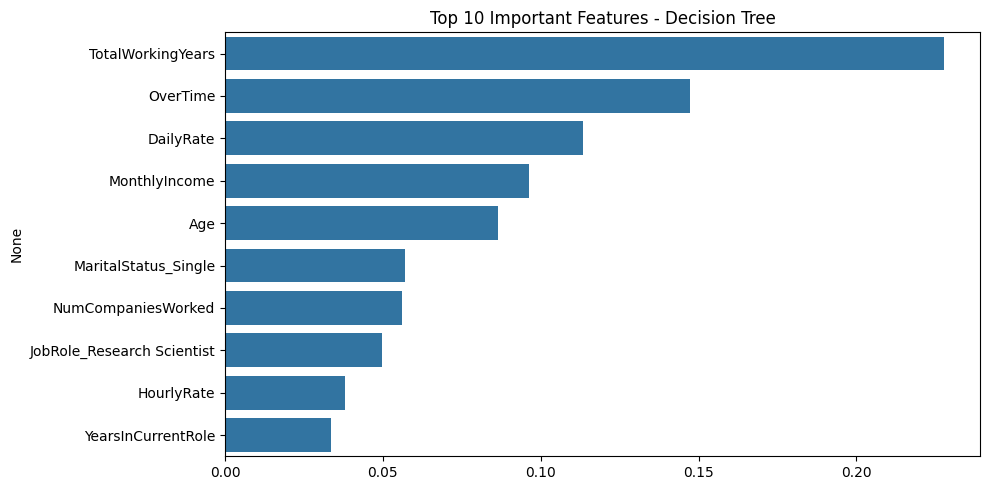

In [27]:
plt.figure(figsize=(10, 5))
sns.barplot(x=importances.values, y=importances.index)
plt.title("Top 10 Important Features - Decision Tree")
plt.tight_layout()
plt.show()

Trích xuất Rules:

In [28]:
# Xuất các rules của cây
rules = export_text(dt, feature_names=X_encoded.columns.tolist(), max_depth=3)
print("\n=== Một số luật từ Decision Tree ===")
print(rules)



=== Một số luật từ Decision Tree ===
|--- TotalWorkingYears <= -1.26
|   |--- Age <= -0.37
|   |   |--- JobRole_Research Scientist <= 0.76
|   |   |   |--- HourlyRate <= -0.36
|   |   |   |   |--- class: 1
|   |   |   |--- HourlyRate >  -0.36
|   |   |   |   |--- truncated branch of depth 2
|   |   |--- JobRole_Research Scientist >  0.76
|   |   |   |--- OverTime <= 0.48
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- OverTime >  0.48
|   |   |   |   |--- truncated branch of depth 2
|   |--- Age >  -0.37
|   |   |--- JobSatisfaction <= -0.66
|   |   |   |--- class: 1
|   |   |--- JobSatisfaction >  -0.66
|   |   |   |--- class: 0
|--- TotalWorkingYears >  -1.26
|   |--- OverTime <= 0.48
|   |   |--- WorkLifeBalance <= -1.79
|   |   |   |--- DailyRate <= -0.96
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- DailyRate >  -0.96
|   |   |   |   |--- truncated branch of depth 2
|   |   |--- WorkLifeBalance >  -1.79
|   |   |   |--- NumCompaniesWorked <= 

In [29]:
# Lưu Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': dt.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importance.to_csv("Data/Feature_Importance.csv", index=False)
print("✅ Đã lưu Feature Importance vào file: Data/Feature_Importance.csv")

✅ Đã lưu Feature Importance vào file: Data/Feature_Importance.csv


##### ✅ 2. Dự đoán Top 10 nhân viên có nguy cơ nghỉ cao → Logistic Regression
- Logistic Regression có ROC AUC cao hơn (~0.84) → mô hình phân biệt ai nghỉ tốt hơn.

- Xác suất nghỉ việc từ predict_proba() có độ tin cậy cao hơn.

- Phù hợp để lọc danh sách nhân viên "cảnh báo sớm".

👉 Nên dùng LogisticRegression.predict_proba() để tính Attrition_Probability.

In [30]:
# Trích xuất top 10 nhân viên có nguy cơ nghỉ cao
df_raw_filtered = df_raw.loc[X_test.index].copy()
df_raw_filtered['Attrition_Probability'] = y_proba_lr  # ← thay thế ở đây


columns_to_export = [
    'EmployeeNumber', 'Department', 'JobRole', 'Attrition_Probability',
    'OverTime', 'JobSatisfaction', 'WorkLifeBalance',
    'EnvironmentSatisfaction', 'Age', 'MonthlyIncome'
]

df_top10 = df_raw_filtered[columns_to_export].sort_values(
    by='Attrition_Probability', ascending=False).head(10)

# Đổi tên cột và làm tròn xác suất
df_top10.rename(columns={'EmployeeNumber': 'EmployeeID'}, inplace=True)
df_top10['Attrition_Probability'] = df_top10['Attrition_Probability'].round(3)

# Định nghĩa lý do nghỉ
def explain_reason(row):
    reasons = []
    if row['Age'] < 25:
        reasons.append("Tuổi trẻ")
    if row['MonthlyIncome'] < 3000:
        reasons.append("Thu nhập thấp")
    if row['OverTime'] == 'Yes' or row['OverTime'] == 1:
        reasons.append("Làm thêm nhiều")
    if row['JobSatisfaction'] <= 2:
        reasons.append("Không hài lòng công việc")
    if row['WorkLifeBalance'] <= 2:
        reasons.append("Cân bằng cuộc sống kém")
    if row['EnvironmentSatisfaction'] <= 2:
        reasons.append("Môi trường làm việc chưa tốt")
    return "; ".join(reasons)

df_top10['RiskReason'] = df_top10.apply(explain_reason, axis=1)





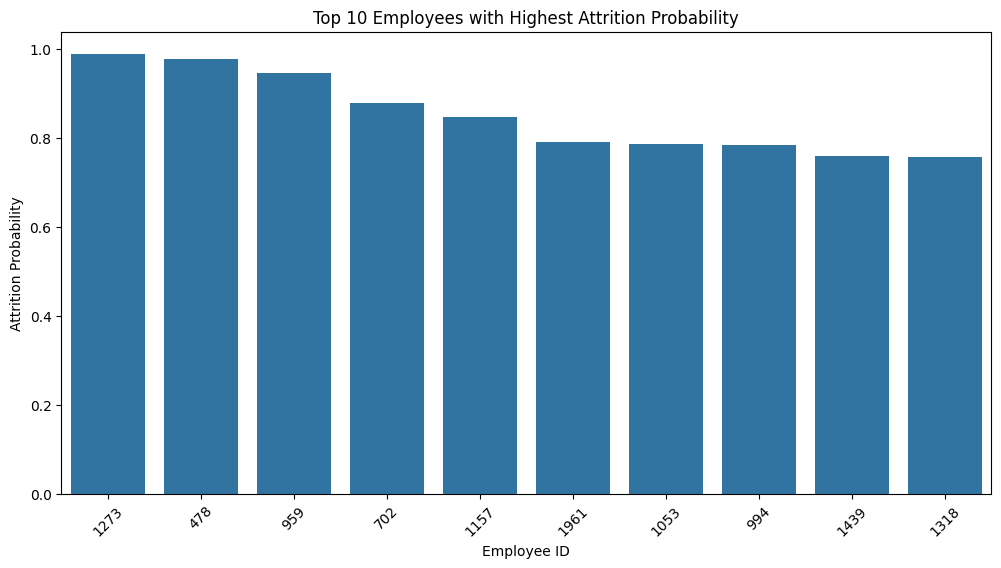

In [31]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_top10, x='EmployeeID', y='Attrition_Probability', order=df_top10['EmployeeID'])
plt.title('Top 10 Employees with Highest Attrition Probability')
plt.xlabel('Employee ID')
plt.ylabel('Attrition Probability')
plt.xticks(rotation=45)
plt.show()


In [32]:
# Xuất file CSV
df_top10.to_csv("Data/Top_10_High_Attrition.csv", index=False)
print("\n✅ Đã lưu file: Data/Top_10_High_Attrition.csv")


✅ Đã lưu file: Data/Top_10_High_Attrition.csv


#### 5. Kết luận giai đoạn 5
Mô hình cho thấy OverTime, Thu nhập, và thời gian làm việc là các yếu tố ảnh hưởng nhiều nhất đến nghỉ việc.

Decision Tree được chọn vì dễ giải thích, phù hợp với mục tiêu ra quyết định trong HR.

Có thể tích hợp mô hình này vào dashboard để cảnh báo sớm nguy cơ nghỉ việc.